In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

2023-06-29 19:38:18.110426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 19:38:18.111759: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 19:38:18.140091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 19:38:18.140618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 19:38:18.891820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Load the processed CSV file

In [2]:
input_file = './data/processed_data.csv'

In [3]:
df = pd.read_csv(input_file)

Remove rows with NaN values

In [4]:
df.dropna(inplace=True)

In [5]:
df = df[df["Month"] == 7]

df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y%m%d%H%M")

Define the threshold for removing extreme Y values

In [6]:
threshold = 3  # Adjust this value based on your dataset and requirements

Calculate the mean and standard deviation of Y

In [7]:
mean_Y = np.mean(df['Temperature'])
std_Y = np.std(df['Temperature'])

Define the range of acceptable Y values

In [8]:
lower_bound = mean_Y - threshold * std_Y
upper_bound = mean_Y + threshold * std_Y

Filter out rows with Y values outside the acceptable range

In [9]:
df = df[(df['Temperature'] >= lower_bound) & (df['Temperature'] <= upper_bound)]

Extract the columns

In [10]:
X = df[['Month', 'Date', 'Time', 'Previous Day Average', 'Two Days Before Average', 'Three Days Before Average', 'Last 7 Days Average', 'Previous Day Wind Speed', 'Previous Day Rainfall']].values
Y = df['Temperature'].values

Normalize X values

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Split the data into training and testing sets

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Define the model architecture

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer with 1 unit for air temperature
])

2023-06-29 19:38:20.324391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1579] failed to query PCI bus id for device: UNKNOWN ERROR (801)
2023-06-29 19:38:20.324433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:970] no PCI bus ID for device ordinal: 0
2023-06-29 19:38:20.326443: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss="mean_absolute_error")

Define early stopping and learning rate scheduler

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

Train the model

In [16]:
history = model.fit(X_train, Y_train, epochs=500, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/500


140/140 [==============================] - 2s 7ms/step - loss: 3.5471 - val_loss: 5.0378 - lr: 0.0010
Epoch 2/500
140/140 [==============================] - 1s 5ms/step - loss: 1.3821 - val_loss: 1.9151 - lr: 0.0010
Epoch 3/500
140/140 [==============================] - 1s 5ms/step - loss: 1.3186 - val_loss: 1.1523 - lr: 0.0010
Epoch 4/500
140/140 [==============================] - 1s 5ms/step - loss: 1.2635 - val_loss: 1.0209 - lr: 0.0010
Epoch 5/500
140/140 [==============================] - 1s 5ms/step - loss: 1.2251 - val_loss: 1.1229 - lr: 0.0010
Epoch 6/500
140/140 [==============================] - 1s 5ms/step - loss: 1.2301 - val_loss: 1.4102 - lr: 0.0010
Epoch 7/500
140/140 [==============================] - 1s 6ms/step - loss: 1.1950 - val_loss: 1.0562 - lr: 0.0010
Epoch 8/500
140/140 [==============================] - 1s 6ms/step - loss: 1.1949 - val_loss: 1.5858 - lr: 0.0010
Epoch 9/500
140/140 [==============================] - 1s 6ms/step - loss: 1.2036 - val_loss: 1.0825

Evaluate the model

In [17]:
loss = model.evaluate(X_test, Y_test)
print("Test loss:", loss)

70/70 [==============================] - 0s 1ms/step - loss: 0.6507
Test loss: 0.6506883502006531


Make predictions

In [18]:
predictions = model.predict(X_test)

70/70 [==============================] - 0s 1ms/step


Calculate accuracy and mean squared error (MSE)

In [19]:
from sklearn.metrics import mean_absolute_error
accuracy = 100 - np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
mse = mean_squared_error(Y_test, predictions)
mas = mean_absolute_error(Y_test, predictions)

In [20]:
print("Accuracy:", accuracy)
print("Mean Squared Error (MSE):", mse)

Accuracy: 93.9768051183877
Mean Squared Error (MSE): 0.8189053774039593


Plot error (predicted - actual)

In [21]:
error = predictions.flatten() - Y_test

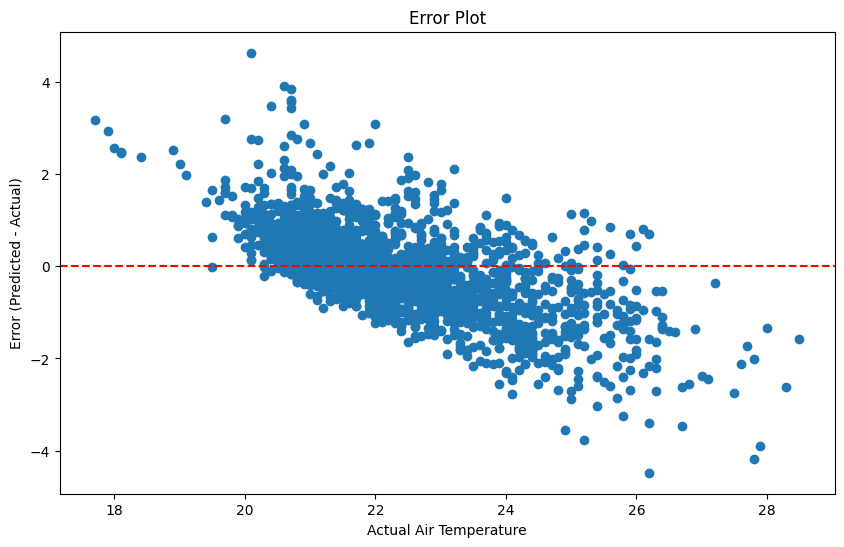

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, error)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Air Temperature')
plt.ylabel('Error (Predicted - Actual)')
plt.title('Error Plot')
plt.show()

Plot training and validation loss over epochs

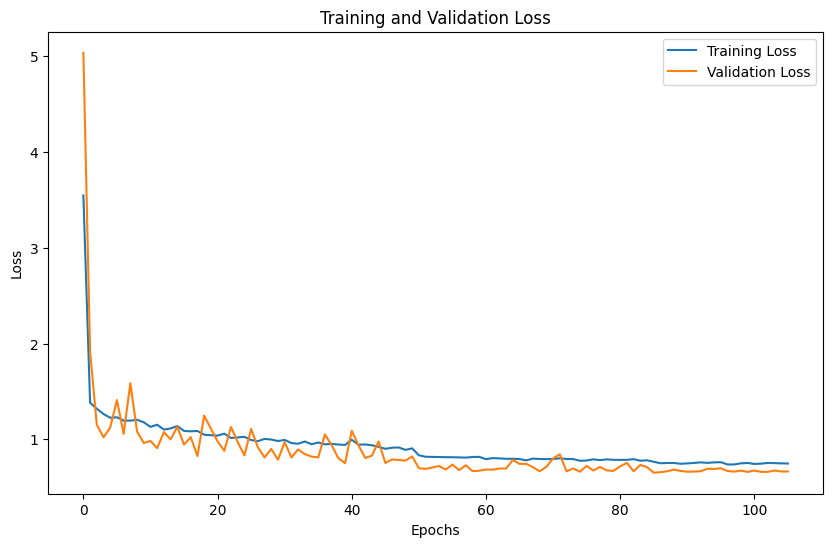

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Print some example predictions

In [24]:
for i in range(10):
    print("Predicted:", predictions[i])
    print("Actual:", Y_test[i])
    print()

Predicted: [22.279829]
Actual: 22.8

Predicted: [21.60152]
Actual: 21.5

Predicted: [22.094042]
Actual: 21.7

Predicted: [23.509521]
Actual: 23.2

Predicted: [21.507627]
Actual: 21.5

Predicted: [23.286432]
Actual: 23.5

Predicted: [21.353247]
Actual: 21.7

Predicted: [25.86925]
Actual: 25.6

Predicted: [21.092888]
Actual: 20.6

Predicted: [21.091444]
Actual: 21.4



Save the TensorFlow model

In [25]:
model.save("./model.keras")